In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/loan-default-dataset/Loan_Default.csv


# Data Cleaning & Transformation

In [2]:
data = pd.read_csv('/kaggle/input/loan-default-dataset/Loan_Default.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [3]:
# Unique values of each categorical feature:

for col in data.columns:
    if data[col].dtypes == object:
        print(col + ' ' + '-'*(30-len(col)) + ' ', data[col].unique())
    else:
        pass

loan_limit --------------------  ['cf' nan 'ncf']
Gender ------------------------  ['Sex Not Available' 'Male' 'Joint' 'Female']
approv_in_adv -----------------  ['nopre' 'pre' nan]
loan_type ---------------------  ['type1' 'type2' 'type3']
loan_purpose ------------------  ['p1' 'p4' 'p3' 'p2' nan]
Credit_Worthiness -------------  ['l1' 'l2']
open_credit -------------------  ['nopc' 'opc']
business_or_commercial --------  ['nob/c' 'b/c']
Neg_ammortization -------------  ['not_neg' 'neg_amm' nan]
interest_only -----------------  ['not_int' 'int_only']
lump_sum_payment --------------  ['not_lpsm' 'lpsm']
construction_type -------------  ['sb' 'mh']
occupancy_type ----------------  ['pr' 'sr' 'ir']
Secured_by --------------------  ['home' 'land']
total_units -------------------  ['1U' '2U' '3U' '4U']
credit_type -------------------  ['EXP' 'EQUI' 'CRIF' 'CIB']
co-applicant_credit_type ------  ['CIB' 'EXP']
age ---------------------------  ['25-34' '55-64' '35-44' '45-54' '65-74' '>74' '<2

**Understanding some abbreviations and their meaning:**
* Loan limit: CF (conforming) or NCF (non-conforming). Conforming loans meet the criteria for purchases by Fannie Mae or Freddie Mac to issue MBS, thus usually have lower interest or downpayment. ([source](https://www.quickenloans.com/learn/what-is-a-conforming-loan))
* Approveal in advance (approv_in_adv): as the name suggests.
* Open credit: whether the borrower is allowed to borrow more money.
* Neg ammortization: A negative amortization loan is one in which unpaid interest is added to the balance of unpaid principal. ([source](https://www.investopedia.com/terms/n/negativeamortization.asp)) 
* Construction type: SB (splash block) or MH (manhole)
* Occupancy type: PR, SR, and IR refer to primary, secondary and investment. Financial risks increase with the latter ones, so do interest rates. ([soure](https://www.homelendingpal.com/how-mortgage-lenders-determine-interest-rates-based-on-occupancy-types/))
* Credit type: EXP = Experian, EQUI = Equifax, CRIF = CRIF Highmark, CIB = CIBIL. These are different credit reporting agencies. The main differences come down to the credit score calculations used and how they process information. ([source](https://www.chase.com/personal/credit-cards/education/credit-score/credit-bureau-differences) and [source](https://en.wikipedia.org/wiki/Credit_bureau))
* Submission of application: *to_inst* seems to refer to a special method for loan approval, i.e. instance-based method. Read more at ([source](https://www.sciencedirect.com/science/article/pii/S0957417421002396)).
* Security type: Direct or Indirect. Direct security means the borrower uses the mortgaged house to pledge against the loan. ([source](https://corporatefinanceinstitute.com/resources/commercial-lending/direct-security/#:~:text=To%20conclude%2C%20direct%20securities%20are,the%20borrower%20default%20on%20it.))


In [4]:
# Remove features that are deemed to have insignificant impact on default

loan = data.copy()
loan.drop(columns=[
    'ID' ,'loan_limit' ,'Gender', 'construction_type', 'Secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'Region', 'Neg_ammortization', 'year', 'submission_of_application' , 'approv_in_adv'
], axis=1, inplace=True)

In [5]:
loan.describe()

,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,1.486700e+05,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.000000,133572.000000,148670.000000,124549.000000
mean,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,1.839093e+05,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478,0.000000,5.000000
25%,1.965000e+05,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.000000,60.474860,0.000000,31.000000
50%,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.000000,75.135870,0.000000,39.000000
75%,4.365000e+05,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.000000,86.184211,0.000000,45.000000
max,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000,61.000000


Almost 25% of the loans are defaults (mean value of Status). The dataset is imbalance but not significantly. Noticably there are some loans where income = 0 and most of them defaulted as shown below.

In [6]:
zero_income = loan[loan['income']==0]
zero_income.groupby(['Status'])['Status'].count()

Status
0       8
1    1252
Name: Status, dtype: int64

In [7]:
# Checking for duplicates

print('Number of duplicated records: ', len(loan[loan.duplicated() == True]))

Number of duplicated records:  1


In [8]:
# Remove duplicates and double check

loan.drop_duplicates()
print('Number of duplicated records: ', len(loan[loan.duplicated() == True]))

Number of duplicated records:  1


In [9]:
# Checking for missing data

print('Pecentage of missing data:       %')
print('----------------------------------')
round(loan.isna().sum()/loan.count() * 100,2).sort_values()

Pecentage of missing data:       %
----------------------------------


loan_type                  0.00
Security_Type              0.00
Credit_Score               0.00
occupancy_type             0.00
lump_sum_payment           0.00
Status                     0.00
interest_only              0.00
loan_amount                0.00
business_or_commercial     0.00
open_credit                0.00
Credit_Worthiness          0.00
term                       0.03
loan_purpose               0.09
age                        0.13
income                     6.56
property_value            11.30
LTV                       11.30
dtir1                     19.37
rate_of_interest          32.47
Interest_rate_spread      32.70
Upfront_charges           36.36
dtype: float64

Handling missing values in each feature should be dealt with separately because they have different characteristics. It should also be done in a specific order to account for their relationship. 

* Term, loan_purpose, age: fill with the most popular value since missing values are insignificant.
* income, property_value, rate_of_interest, Interest_rate_spread, Upfront_charges: fill with mean value. (AFD)
* LTV, dtir1: fill with the result of calculations from loan amount, property value, and income. Since there are records with income=0, we will replace 0 with the mean value of income before performing divisions. (AFD)

For future development, read more about different methods [here](https://www.analyticsvidhya.com/blog/2021/10/handling-missing-value/#:~:text=Impute%20with%20Averages%20or%20Midpoints,method%20can%20preserve%20data%20integrity.) and [here](https://medium.com/@pingsubhak/handling-missing-values-in-dataset-7-methods-that-you-need-to-know-5067d4e32b62#).

(AFD: Area for development)

Before we modify the dataset, we would want to know whether we will be modifying default records. As shown below, rows with misisng values are non-default loans only. So we will not modify any data of default loans, fortunately.

In [10]:
data.isna().groupby('Status').sum()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,dtir1
Status,,,,,,,,,,,,,,,,,,,,,
False,0,0,3344,0,908,0,134,0,0,0,...,9150,0,0,0,200,200,15098,0,0,24121


In [11]:
# Fill with most popular value
g1 = ['term', 'loan_purpose', 'age', ]
for col in g1:
    loan[col] = loan[col].fillna(loan[col].value_counts().keys()[0])

# Fill with mean
g2 = ['income', 'property_value', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges']
for col in g2:
    loan[col] = loan[col].fillna(loan[col].mean())
    
# Replace 0 with mean
loan['income'] = loan['income'].replace(0, loan['income'].mean())
    
# Fill with calculated values
loan['LTV'] = loan['LTV'].fillna(loan['loan_amount'] / loan['property_value'])
loan['dtir1'] = loan['dtir1'].fillna(loan['loan_amount'] / loan['income']) 

In [12]:
# Change the data type of Status to categorical

loan = loan.astype({'Status': 'object'})

In [13]:
loan.describe()

,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,dtir1
count,1.486700e+05,148670.000000,148670.000000,148670.000000,148670.000000,1.486700e+05,148670.000000,148670.000000,148670.000000,148670.000000
mean,3.311177e+05,4.045476,0.441656,3224.996127,335.143438,4.978935e+05,7016.303341,699.789103,65.426067,40.500625
std,1.839093e+05,0.487764,0.445359,2784.133285,58.402488,3.411696e+05,6260.537217,115.875857,43.695528,18.232419
min,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,60.000000,500.000000,0.033140,1.961806
25%,1.965000e+05,3.750000,0.181500,1250.000000,360.000000,2.880000e+05,3900.000000,599.000000,54.584352,32.000000
50%,2.965000e+05,4.045476,0.441656,3224.996127,360.000000,4.580000e+05,6120.000000,699.000000,73.026316,40.000000
75%,4.365000e+05,4.250000,0.620000,3889.495000,360.000000,5.980000e+05,8280.000000,800.000000,84.722222,47.000000
max,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,2455.000000


## Univariate Analysis

In [14]:
# Grouping features for visualization
input_1 = ['loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'term', 'interest_only', 'lump_sum_payment', 'occupancy_type', 'Credit_Score', 'age', 'Security_Type']
input_2 = ['loan_amount', 'Upfront_charges', 'property_value', 'income', ]
input_3 = ['rate_of_interest', 'Interest_rate_spread', 'LTV', 'dtir1']

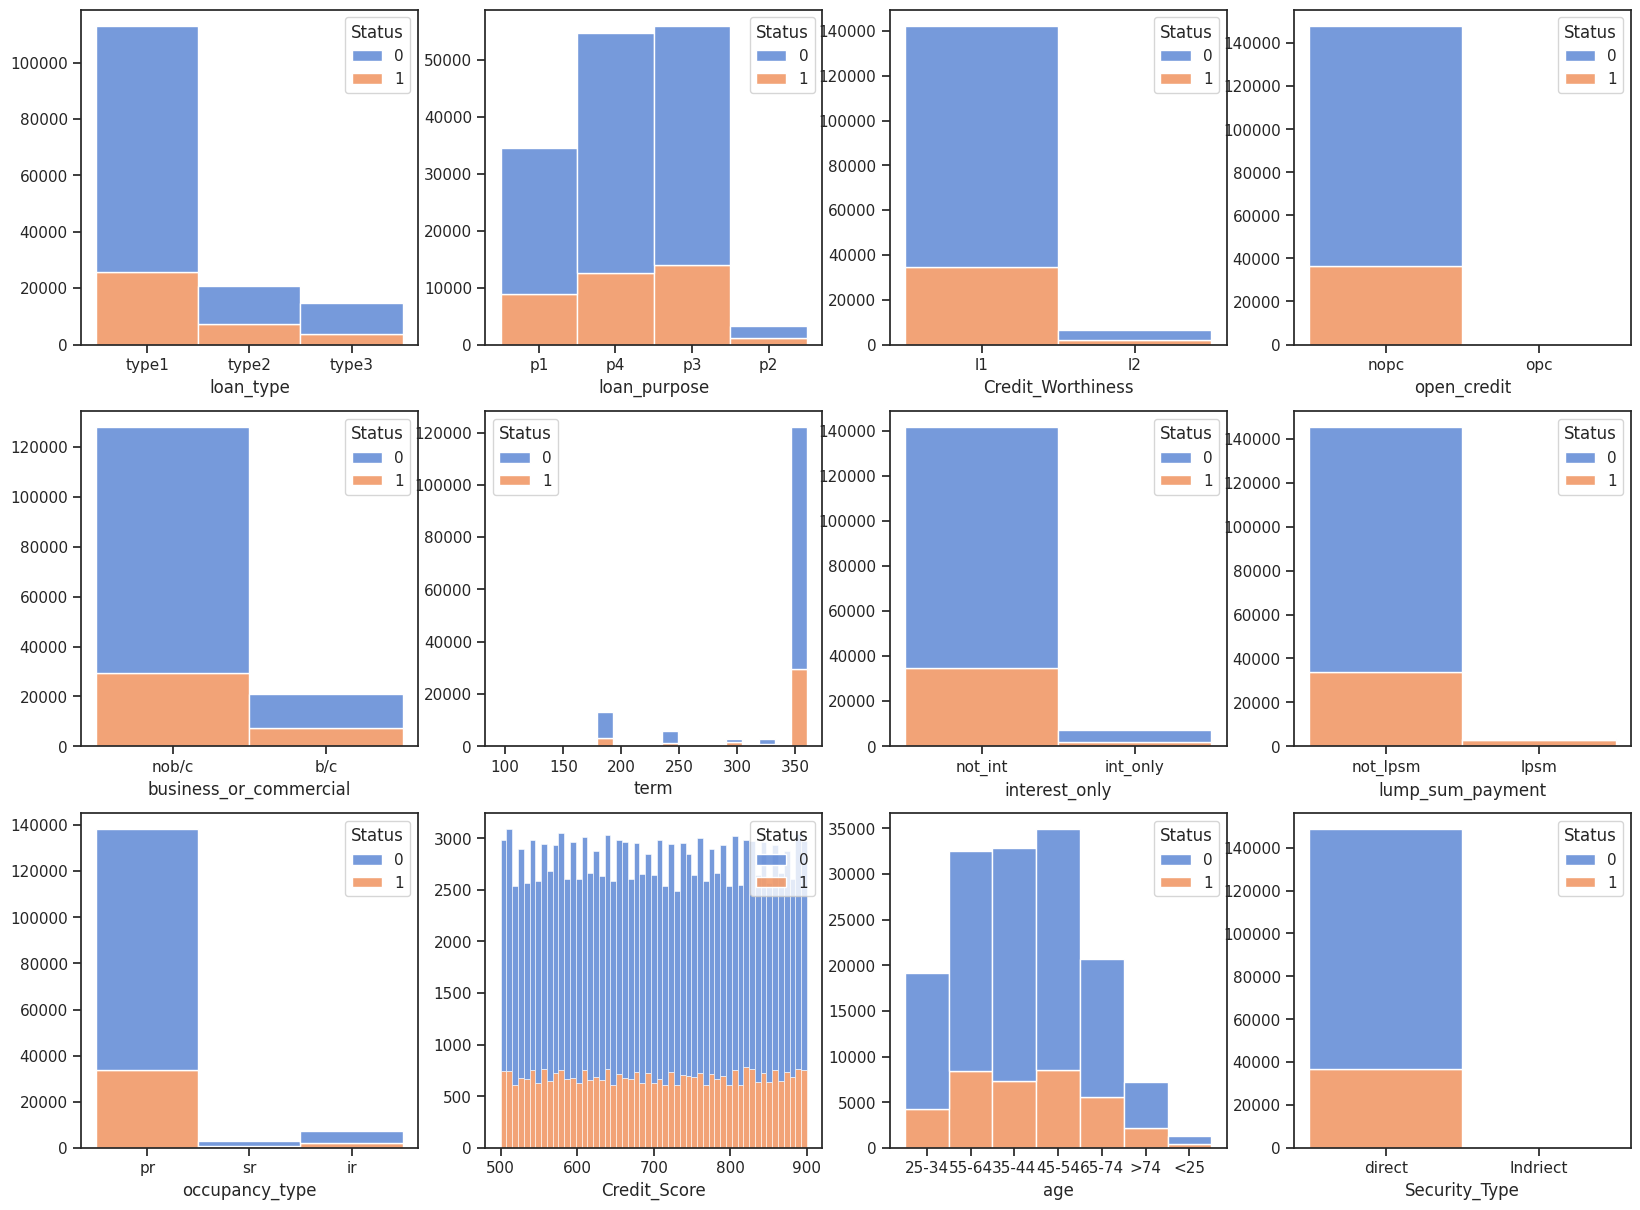

In [15]:
# Distribution of group 1

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")

sns.set_theme(style="ticks", palette="muted")
f1 = plt.figure(figsize=(20,20))
for col in input_1:
    i = input_1.index(col) + 1
    ax = f1.add_subplot(4,4,i)
    g1 = sns.histplot(loan, x=loan[col], legend=True, hue='Status', multiple='stack')
    g1.set(ylabel=None)

Interestingly, *Credit_Score* does not seem to have a remarkable impact to default. Across all levels, the ratio of defaults/non-defaults is fairly stable. We can remove this feature from the dataset.

*open_credit* and *Security_Type* are not very helpful because there are no or almost no records with open credit or indirect security, respectively. We can verify it by looking at the total of records with each feature.

In [16]:
loan.groupby(by=['Status','Security_Type'])['open_credit'].count()

Status  Security_Type
0       direct           112031
1       Indriect             33
        direct            36606
Name: open_credit, dtype: int64

In [17]:
loan.groupby(by=['Status','open_credit'])['Security_Type'].count()

Status  open_credit
0       nopc           111573
        opc               458
1       nopc            36541
        opc                98
Name: Security_Type, dtype: int64

In [18]:
# Remove Credit_Score, open_credit and Security_Type

loan = loan.drop(['open_credit', 'Security_Type', 'Credit_Score'], axis=1)

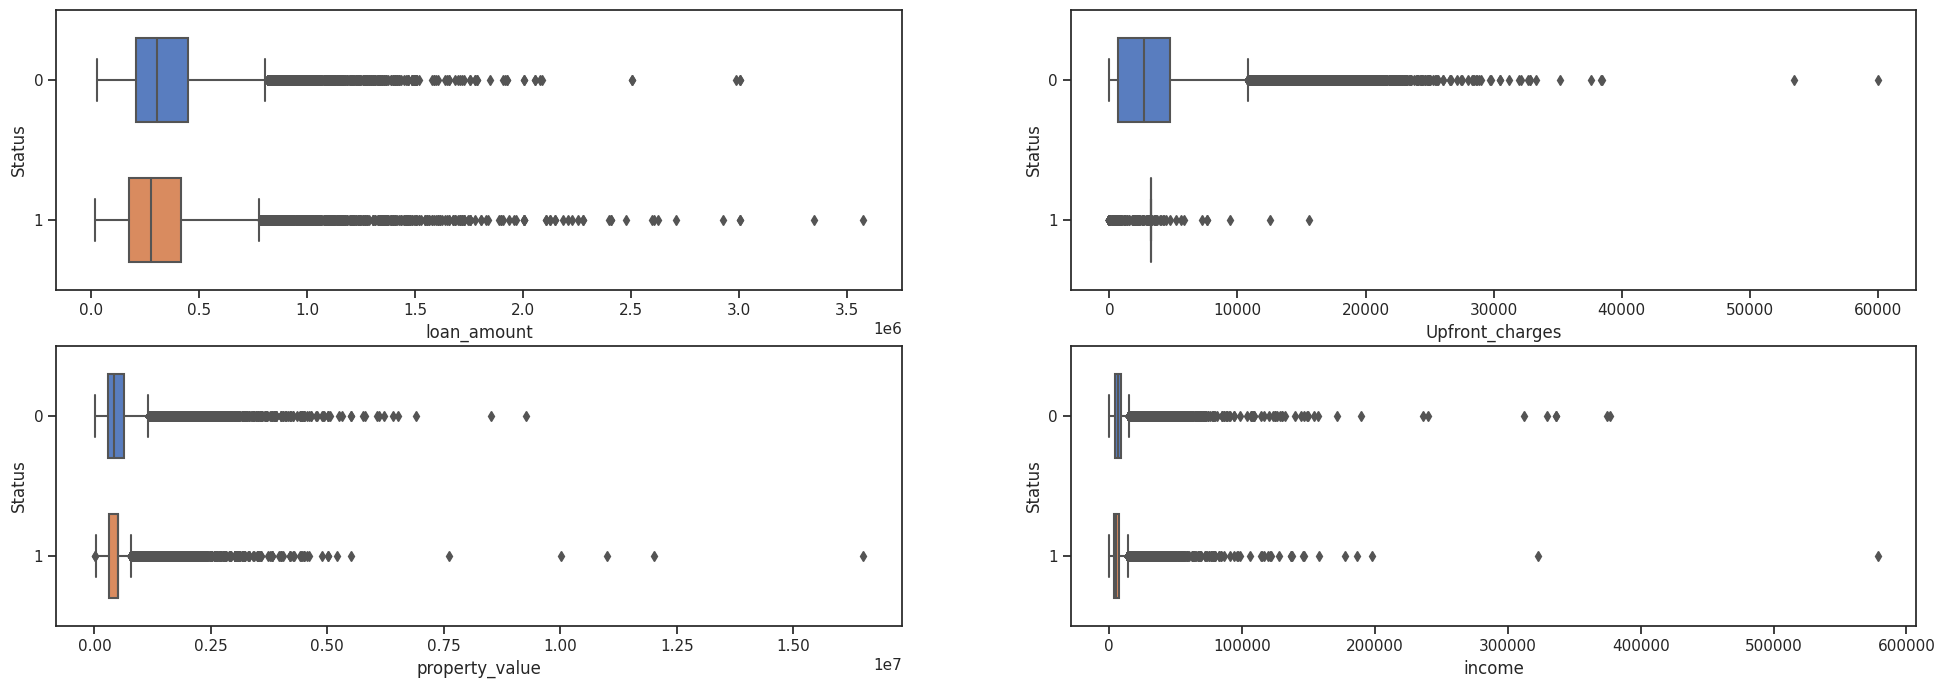

In [19]:
# Distribution of group 2 

f2 = plt.figure(figsize=(24,8))
for col in input_2:
    i = input_2.index(col) + 1
    ax = f2.add_subplot(2,2,i)
    g2 = sns.boxplot(loan, x=col, y='Status', width=.6, orient='h')

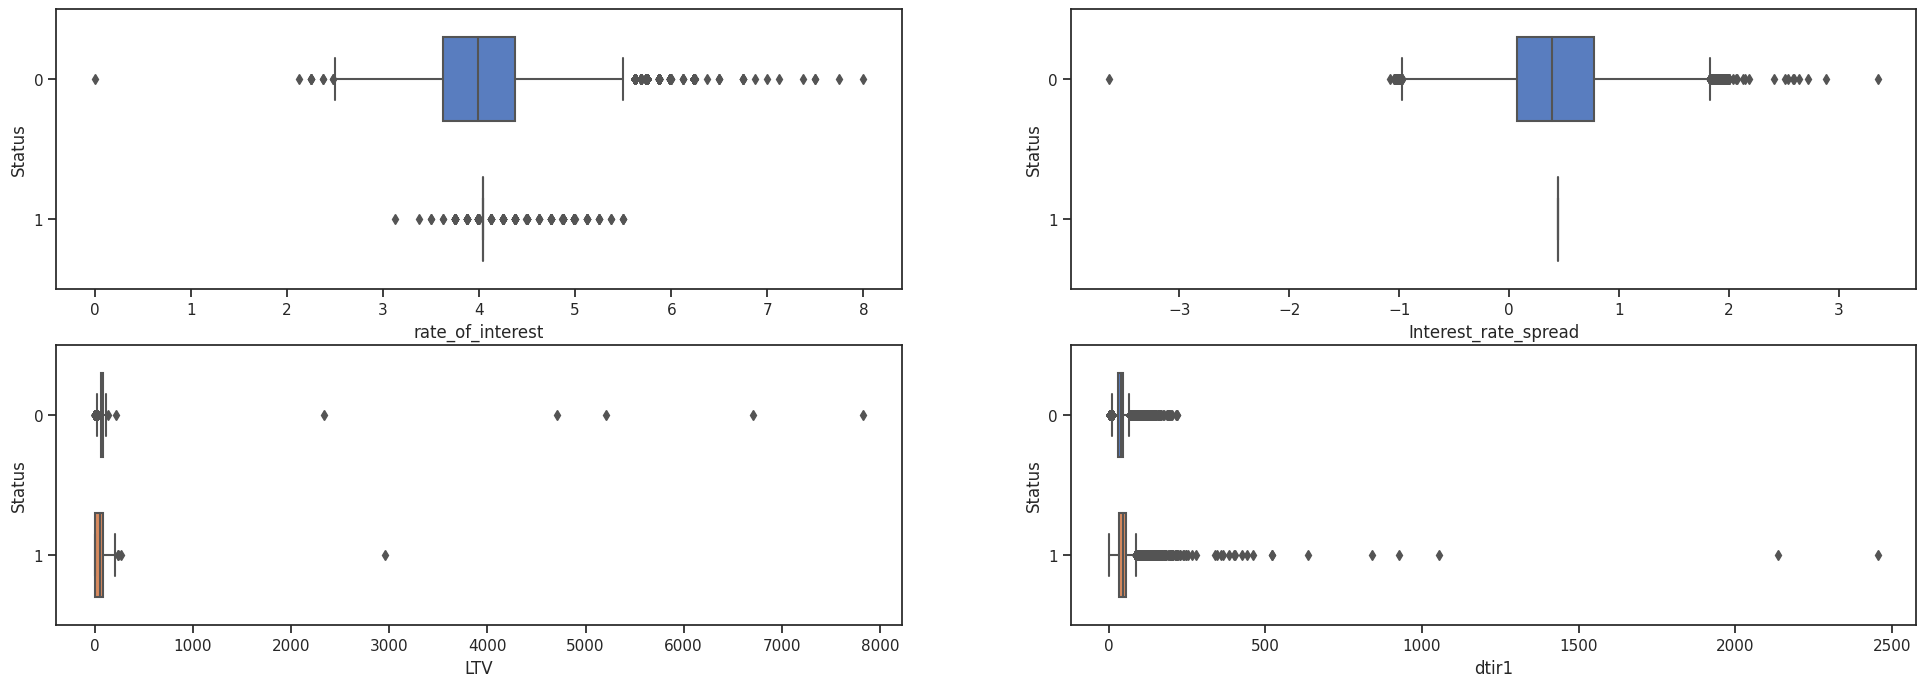

In [20]:
# Distribution of group 3

f3 = plt.figure(figsize=(24,8))
for col in input_3:
    i = input_3.index(col) + 1
    ax = f3.add_subplot(2,2,i)
    g3 = sns.boxplot(loan, x=col, y='Status', width=.6, orient='h')

We need to keep in mind that *property_value*, *rate_of_interest*, *Interest_rate_spread* and *Upfront_charges* have a lot of missing data (11-30%) and have been filled with the mean value. *LTV* and *dtir1* also have a lot of missing data and were calculated with the filled data of other features.